# Scripts for CPlantBox

 [CPlantBox](https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox) is a functional structural plant model. It is currently underconstruction. But some of the functions are already working. There are serveral ways to use the CPlantBox, which are:
 

 1. Python Scripts.
 2. C++ source file for building and compiling.
 3. Precompiled programm for windows.
 4. Online application.

Among them the the python scripting is the recommended and most robust way. If you have not tried a 3D visualized plant you can [click Here (a visualized CPlantBox output)](http://xrzhou.com/content/vtkjs/GeometryViewer/GeometryViewer.html?fileURL=http://xrzhou.com/content/1-projects/leaf.vtp).

In this notebook, we can see how the CPlantBox is working and how to play around with it. Tutorial part is similar to CRootBox tutorial written by [Daniel Leitner](http://www.simwerk.at/contact/). R code part are mainly written by [Guillaume Lobet](http://www.guillaumelobet.be/).

## 1.Read parameter file and generate a simple output

In line7, we could change the parameter name inside the qoutation marks, if we want to use different parameter. Normally we use the XML based parameter file. If you are using a .rparam file frome the CRootBox, you can directly use them here, but after the first run the new Parameter file is generated, and you can further use the new file later on.

In [2]:
import py_plantbox as pb # Open  and root parameter from a file
from rb_tools import *

plant = pb.Plant()

# Open  and root parameter from a file
name = "AnaPG2018" # you can change it to the name of other XML parameter files for example""
plant.openXML(name)

# Initialize
plant.initialize()


for dt in range (0,60):
    plant.simulate(dt)
    

# Simulate
#plant.simulate(60, True)

# Export final result (as vtp)
#2 = root
#4 = stem
#8 = leaf
#15 = all
analysis = pb.SegmentAnalyser(plant) 
analysis.write("results/Ana.vtp") #to generate the .vtp file
analysis.write("results/Ana.txt") #to generate the matlab file



IndexError: invalid vector<T> subscript

## 2. Data analysis using R
In the following blocks of section 2, R is used as programming language for data analysis and visualiztion. First we use _warnings_ and _rpy2_ package in python.

In [12]:
# Hide warnings if there are any
import warnings
import rpy2.ipython
warnings.filterwarnings('ignore')
# Load in the r magic package
%load_ext rpy2.ipython
# We need ggplot2


### 2.1 Visualiztion of different organ length

In [13]:

%%R 
library(plyr)
library(tidyverse)

 rs <- read_delim("results/example_1a.txt",  delim = " ") %>%
  mutate(time = round(time)) %>%
  mutate(length = sqrt((x2-x1)^2 + (y2-y1)^2 + (z2-z1)^2))

 rs2 <- ddply(rs, .(type, organ, time), summarise, length=sum(length)) %>%
   filter(time > 0)



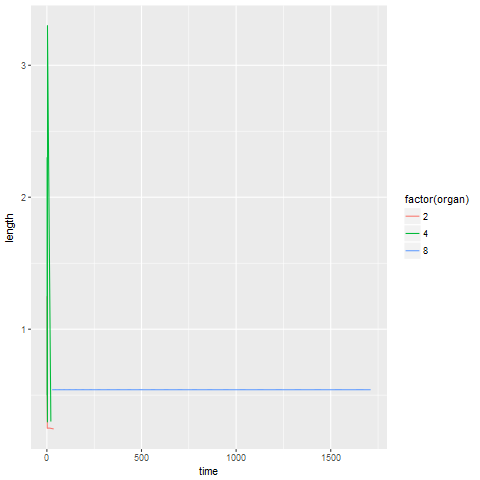

TypeError: 'rpy2.rinterface.RNULLType' object is not iterable

R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000020E73D6E548 / R:0x0000020E00E995B8>
[ListVector, Environment, ListVector]
R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000020E73D6E548 / R:0x0000020E00E995B8>
[ListVector, Environment, ListVector]
  layout: <class 'rpy2.robjects.environments.Environment'>
  R object with classes: ('Layout', 'ggproto') mapped to:
<Environment - Python:0x0000020E75036948 / R:0x0000020E017D1E08>
R object with classes: ('list',) mapped to:
<ListVector - Python:0x0000020E73D6E548 / R:0x0000020E00E995B8>
[ListVector, Environment, ListVector]

In [14]:
%R print(ggplot(rs2, aes(time, length, colour=factor(organ))) +    geom_line())

## 4. "screenshot" of the 3D architecture
In this paragraph, we can could use a 2D "screenshot" to show the output. There are 3 ways to do it. In this notebook, we can use 2 ways which are
1. using R and gganimate to generate the animation
2. using VTK package 

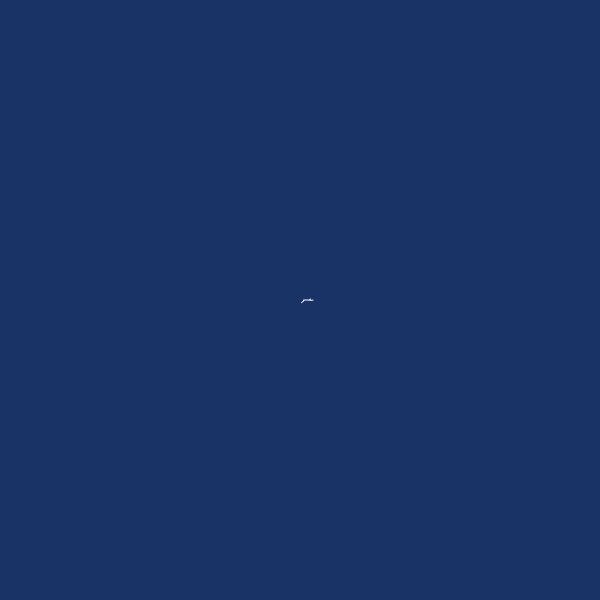

In [6]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/example_1a.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(500, 10, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )


iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
    
renWin.Render()

windowToImageFilter = vtkWindowToImageFilter()
windowToImageFilter.SetInput(renWin)
windowToImageFilter.Update()


writer = vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = bytearray(memoryview(writer.GetResult()))

Image(data)

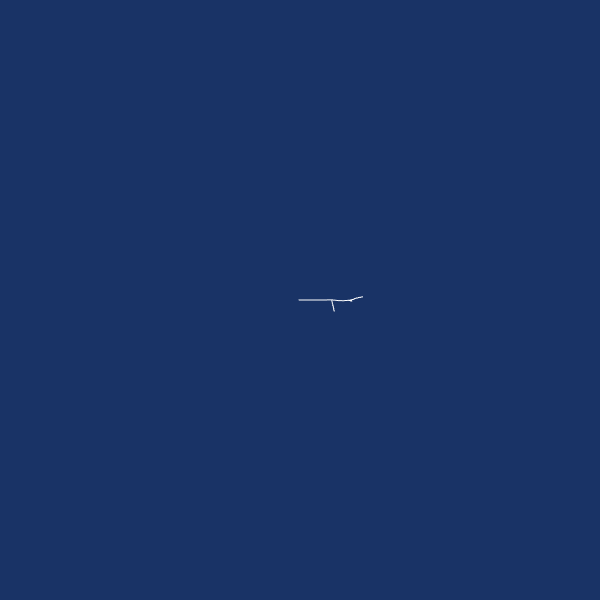

In [7]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/example_5a.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(100, 100, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )

 

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
    

renWin.Render()


windowToImageFilter = vtkWindowToImageFilter()
windowToImageFilter.SetInput(renWin)
windowToImageFilter.Update()

 

writer = vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = bytearray(memoryview(writer.GetResult()))




Image(data)






True

In [18]:

from IPython.display import HTML
HTML('<iframe width="800" height="600" src="http://xrzhou.com/content/vtkjs/GeometryViewer/GeometryViewer.html?fileURL=http://xrzhou.com/content/1-projects/leaf.vtp" frameborder="0" allowfullscreen></iframe>')

## 4. Python binding with xylem water flux

In [3]:
import scipy.sparse.linalg as LA
from scipy import sparse
import matplotlib.pylab as plt

import py_plantbox as pb
from rb_tools import *

import xylem_flux 

import timeit


# Simulate a root system
name = "Phloem"
plant = pb.Plant()
plant.openXML(name)
plant.initialize()

for i in range (0,30):
    plant.simulate(i)
# for i in range(0,7):
#     plant.simulate(1) 

# Create graph
nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
rseg = seg2a(plant.getSegments(2)) # root system segments
sseg = seg2a(plant.getSegments(4)) # root system segments
seg = np.vstack((sseg,rseg))
print("number of segments",len(seg))

# Adjacency matrix
A = sparse.coo_matrix((np.ones(seg.shape[0]),(seg[:,0],seg[:,1]))) 

# Parameters for flux model
rs_Kr = np.array([ 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-11, 2.e-11 ]) # s/m; root hydraulic radial conductivity per root type 
rs_Kz = np.array([ 5.e-14, 5.e-14, 5.e-14, 5.e-14, 5e-14, 5e-14, 5e-14 ]) # m2*s; root hydraulic axial conductivity per root type 

soil_psi = -700 # static soil pressure J kg^-1

rho = 1e3 # kg / m^3      
g = 1.e-3*9.8065 # m / s^2   

pot_trans = np.array([-1.15741e-10]) # # m^3 s^-1 potential transpiration

# Conversions
plant_ana = pb.SegmentAnalyser(plant) 
radius = v2a(plant_ana.getScalar("radius"))/100. # convert from cm to m
type = v2a(plant_ana.getScalar("subtype"))
kr = np.array(list(map(lambda t: rs_Kr[int(t)-1], type))) # convert from 'per type' to 'per segment'
kr.resize((kr.shape[0],1))
kz = np.array(list(map(lambda t: rs_Kz[int(t)-1], type)))     
kz.resize((kz.shape[0],1))          

print(radius)
# glue together shoot and root segments
shoot1 = np.ones((sseg.shape[0],1))                    
shoot0 = np.ones((sseg.shape[0],1))
radius = np.vstack((shoot1,radius))
kr =  np.vstack((shoot0,kr))
kz =  np.vstack((shoot1,kz))  
            
# Call back function for soil potential
soil = lambda x,y,z : soil_psi

# Calculate fluxes within the root system
Q, b = xylem_flux.linear_system(seg, nodes, radius, kr, kz, rho, g, soil)
# plt.spy(Q)
# plt.show()
Q, b = xylem_flux.bc_neumann(Q, b, np.array([0]), np.array([pot_trans]))


start = timeit.default_timer()
x = LA.spsolve(Q, b, use_umfpack = True) # direct
stop = timeit.default_timer()
print ("linear system solved in", stop - start, " s") 
      
# Save results into vtp 
segP = nodes2seg(nodes,seg,x)# save vtp 
axial_flux = xylem_flux.axial_flux(x, seg, nodes, kz, rho, g)
radial_flux = xylem_flux.radial_flux(x, seg, nodes, radius, kr, soil)
net_flux = axial_flux+radial_flux

plant_ana.addUserData(a2v(segP[sseg.shape[0]:]),"pressure")
plant_ana.addUserData(a2v(axial_flux[sseg.shape[0]:]),"axial_flux")
plant_ana.addUserData(a2v(radial_flux[sseg.shape[0]:]),"radial_flux")
plant_ana.addUserData(a2v(net_flux[sseg.shape[0]:]),"net_flux")

plant_ana.write("results/example_5a.vtp")         


number of segments 436
[[0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00200588]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.00012169]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.00018514]
 [0.00018514]
 [0.00021066]
 [0.00021066]
 [0.00020322]
 [0.00020322]
 [0.00020312]
 [0.00020312]
 [0.00018556]
 [0.00018556]
 [0.0001823 ]
 [0.0001823

In [7]:
import scipy.sparse.linalg as LA
from scipy import sparse
import matplotlib.pylab as plt

import py_plantbox as pb
from rb_tools import *

import xylem_flux 

import timeit


# Simulate a root system
name = "Phloem"

plant = pb.Plant()
plant.openXML(name)
plant.initialize()
plant.simulate(dt)
# for i in range(0,7):
#     plant.simulate(1) 

# Create graph
nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
rseg = seg2a(plant.getSegments(2)) # root system segments
sseg = seg2a(plant.getSegments(4)) # root system segments
seg = np.vstack((sseg,rseg))
print("number of segments",len(seg))

# Adjacency matrix
A = sparse.coo_matrix((np.ones(seg.shape[0]),(seg[:,0],seg[:,1]))) 

# Parameters for flux model
rs_Kr = np.array([ 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-11, 2.e-11 ]) # s/m; root hydraulic radial conductivity per root type 
rs_Kz = np.array([ 5.e-14, 5.e-14, 5.e-14, 5.e-14, 5e-14, 5e-14, 5e-14 ]) # m2*s; root hydraulic axial conductivity per root type 

soil_psi = -700 # static soil pressure J kg^-1

rho = 1e3 # kg / m^3      
g = 1.e-3*9.8065 # m / s^2   

pot_trans = np.array([-1.15741e-10]) # # m^3 s^-1 potential transpiration

# Conversions
plant_ana = pb.SegmentAnalyser(plant) 
radius = v2a(plant_ana.getScalar("radius"))/100. # convert from cm to m
type = v2a(plant_ana.getScalar("subtype"))
kr = np.array(list(map(lambda t: rs_Kr[int(t)-1], type))) # convert from 'per type' to 'per segment'
kr.resize((kr.shape[0],1))
kz = np.array(list(map(lambda t: rs_Kz[int(t)-1], type)))     
kz.resize((kz.shape[0],1))          

print(radius)
# glue together shoot and root segments
shoot1 = np.ones((sseg.shape[0],1))                    
shoot0 = np.ones((sseg.shape[0],1))
radius = np.vstack((shoot1,radius))
kr =  np.vstack((shoot0,kr))
kz =  np.vstack((shoot1,kz))  
            
# Call back function for soil potential
soil = lambda x,y,z : soil_psi

# Calculate fluxes within the root system
Q, b = xylem_flux.linear_system(seg, nodes, radius, kr, kz, rho, g, soil)
# plt.spy(Q)
# plt.show()
Q, b = xylem_flux.bc_neumann(Q, b, np.array([0]), np.array([pot_trans]))


start = timeit.default_timer()
x = LA.spsolve(Q, b, use_umfpack = True) # direct
stop = timeit.default_timer()
print ("linear system solved in", stop - start, " s") 
      
# Save results into vtp 
segP = nodes2seg(nodes,seg,x)# save vtp 
axial_flux = xylem_flux.axial_flux(x, seg, nodes, kz, rho, g)
radial_flux = xylem_flux.radial_flux(x, seg, nodes, radius, kr, soil)
net_flux = axial_flux+radial_flux

plant_ana.addUserData(a2v(segP[sseg.shape[0]:]),"pressure")
plant_ana.addUserData(a2v(axial_flux[sseg.shape[0]:]),"axial_flux")
plant_ana.addUserData(a2v(radial_flux[sseg.shape[0]:]),"radial_flux")
plant_ana.addUserData(a2v(net_flux[sseg.shape[0]:]),"net_flux")

plant_ana.write("results/Phloem.vtp")         


number of segments 118
[[0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00206189]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.00017602]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.002     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]]
linear system solved in 0.0002428717953080195  s


In [10]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/Phloem.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(10, 10, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )

iren = vtk.vtkRenderWindowInteractor()


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )

iren.Initialize()

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)

iren.SetKeyEventInformation(0, 0, 'j' , 0)
iren.InvokeEvent("CharEvent")


renWin.Render()
iren.Start()